In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import data from CSV extracted from Cassandra after Pyspark Process
pd.options.display.colheader_justify = 'right'
Data = pd.read_csv('C:\\Users\\santi\\Downloads\\Data.csv')
Data

,date,score_V
0,2009-04-06,0.116971
1,2009-04-07,0.135128
2,2009-04-08,NaN
3,2009-04-09,NaN
4,2009-04-10,NaN
...,...,...
76,2009-06-21,-0.006375
77,2009-06-22,-0.030599
78,2009-06-23,-0.024182
79,2009-06-24,-0.012015


: 

In [192]:
#Aplly best strategy found in EDA for inputting missing data

def seasonal_mean(ts, n, lr=.7):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

Data['score_V'] = seasonal_mean(Data['score_V'], n=7, lr=1.05)

C:\Users\santi\AppData\Local\Temp\ipykernel_20156\1606205329.py:13: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(ts_seas)):


In [193]:
Data['date']  = pd.to_datetime(Data['date'])

In [194]:
#add exogenous variables
#Data.set_index('date', inplace=True)
Data['Weekday'] = Data['date'].dt.strftime('%A')
Data = Data[['score_V','Weekday']]

<AxesSubplot:ylabel='score_V'>

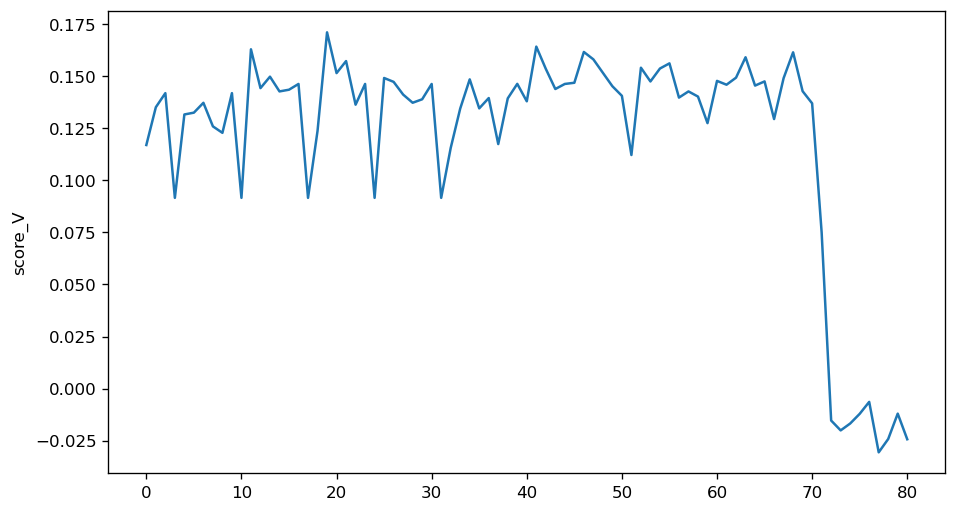

In [195]:
import seaborn
seaborn.lineplot(Data['score_V'])

In [196]:

def weekday_mapping(x):
    week = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6 }

    return week[x]

Data['Weekday'] = Data['Weekday'].apply(weekday_mapping)


C:\Users\santi\AppData\Local\Temp\ipykernel_20156\889199729.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Weekday'] = Data['Weekday'].apply(weekday_mapping)


In [197]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(Data.score_V.values, autolag='AIC')
print(f'p-value: {result[1]}')
if result[1]>.05:
    print("Null Hypothesis (HO): Series is non-stationary, or series has a unit root.")
else:
    print("Alternate Hypothesis(HA): Series is stationary, or series has no unit root.")


p-value: 0.622564960019301
Null Hypothesis (HO): Series is non-stationary, or series has a unit root.


C:\Users\santi\AppData\Local\Temp\ipykernel_20156\2492519450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['score_V'] = signal.detrend(Data['score_V'].values)


Text(0.5, 1.0, 'Detrend Vader score')

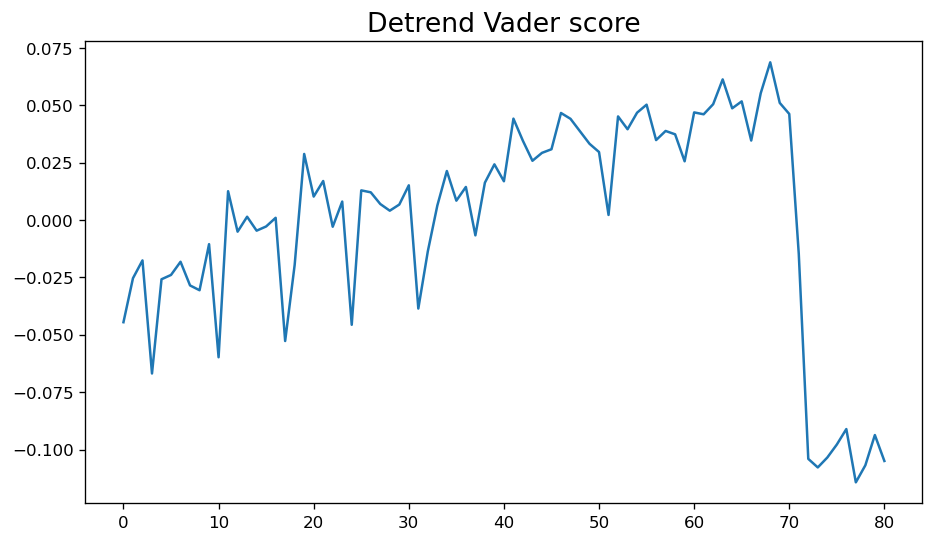

In [198]:
from scipy import signal
Data['score_V'] = signal.detrend(Data['score_V'].values)
plt.plot(Data['score_V'])
plt.title('Detrend Vader score', fontsize=16)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

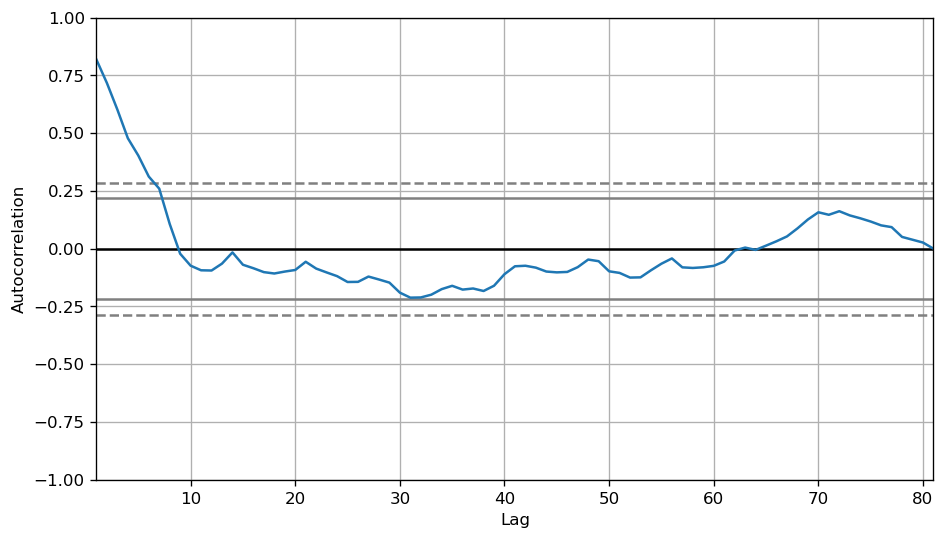

In [199]:
from pandas.plotting import autocorrelation_plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(Data['score_V'].tolist())

In [200]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


steps = 40
data_train = Data[:-steps]
data_test  = Data[-steps:]



forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )

forecaster.fit(y=data_train['score_V'], exog=data_train['Weekday'])
forecaster

predictions = forecaster.predict(steps=steps, exog=data_test['Weekday'])

<AxesSubplot:>

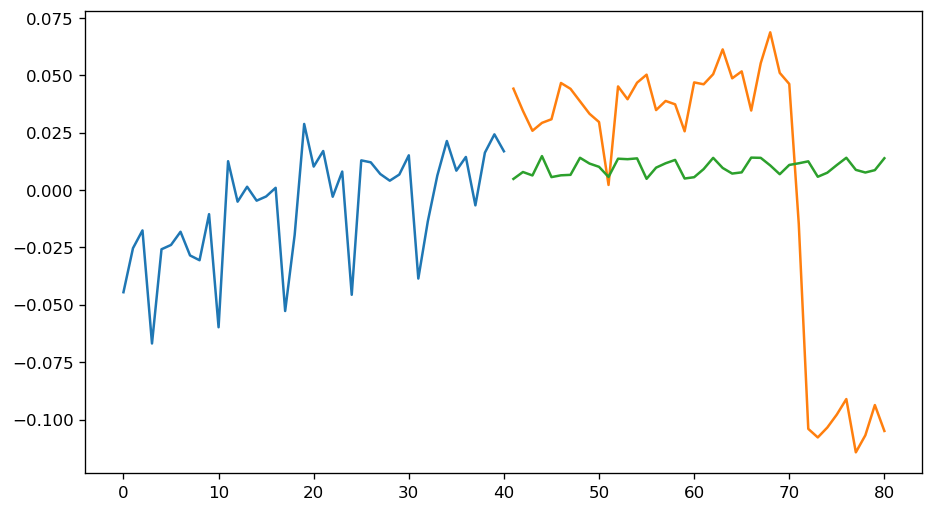

In [201]:
data_train['score_V'].plot(label='train')
data_test['score_V'].plot(label='test')
predictions.plot(label='predictions')

In [202]:
from skforecast.model_selection import grid_search_forecaster
steps = 30
data_train = Data[:-steps]
data_test  = Data[-steps:]

forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 7 )

lags_grid = [2,3,5,7,14]

param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5,4]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['score_V'],
                        exog        = data_train['Weekday'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = steps,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
               )

predictions = forecaster.predict(steps=steps, exog=data_test['Weekday'])

Number of models compared: 20.


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 0.00034001816758721335



<AxesSubplot:>

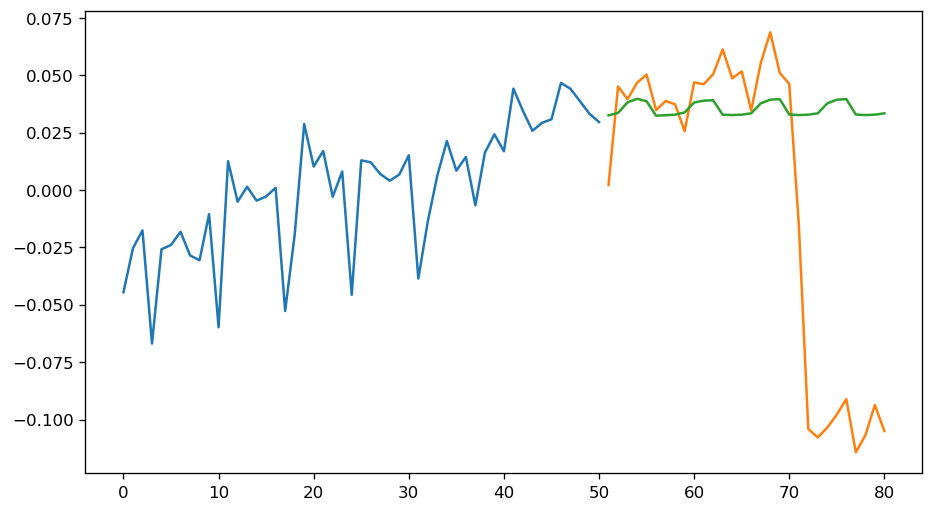

In [203]:
data_train['score_V'].plot(label='train')
data_test['score_V'].plot(label='test')
predictions.plot(label='predictions')